In [2]:
root_path = 'miniconda3'
import sys
sys.path.append(f'{root_path}envs/mp/lib/python3.12.4/site-packages/')

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from mpi4py.MPI import COMM_WORLD
from IPython.display import clear_output, Math, HTML

# Basic Straigth Waveguide 

## Parametization 

in this simulation, the base length unit is $a = 1 \mu m$

In [3]:
cell = mp.Vector3(16,8,0)  # This is the simulation window. Here is defined a 2D-cell with Δx=16um and Δy=8um 

pml_layers = [mp.PML(1.0)]  # Adding an absorbing layer (PML) of thickness 1 μm around all sides of the cell

geometry = [mp.Block(mp.Vector3(mp.inf,1,mp.inf),     # Defines a parallelepiped block of size ∞ × 1 × ∞
                     center=mp.Vector3(),             # Centered at (0,0)
                     material=mp.Medium(epsilon=12))] # Material with ε=12

# By default, any place where there are no objects there is air (ε=1)

is MEEP, we consider $\epsilon_0 = 1~,~~\mu_0 = 1~,~~c = 1$

If $a$ is the base length unit, then the frequency $f$ in MEEP is specified in units of $c/a$. And $\lambda$ (vacuum wavelength) has to be given in units of $a$, so it turns out that $f = \frac{1}{\lambda/a} = a/\lambda$

For example, a frequency of 0.15 for $a = 1 \mu m$ would result in a $\lambda = (1/0.15)~ \mu m = 6.67 \mu m$. For a material with $\epsilon = 12$ this wavelength would be $(6.67/\sqrt{12})~\mu m \approx 2 \mu m$

In [4]:
sources = [mp.Source(mp.ContinuousSource(frequency=0.15),  # Frequency f corresponds to a vacuum wavelength of 1/0.15=6.67 μm
                     component=mp.Ez,                      # Component Ez to specify a eletric current
                     center=mp.Vector3(-7,0))]             # The current is located at (-7,0)

# Is important to leave a little space between sources and the cell boundaries, 
# to keep the boundary conditions from interfering with them.

Meep will discretize this structure in space and time, and that is specified by a single variable "resolution", that gives the number of pixels per distance unit ($a = 1\mu m$).

Setting resolution to 10 pixels/μm corresponds to around 67 pixels/wavelength, or around 20 pixels/wavelength in the high-index material.

In [5]:
resolution = 10

## Simulation

In [6]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

In [7]:
sim.run(until=2000)  # Run until a time of t = 200

-----------
Initializing structure...
time for choose_chunkdivision = 0.000386 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.00921488 s
-----------
run 0 finished at t = 2000.0 (40000 timesteps)


## Analyze

Getting the dieletric region

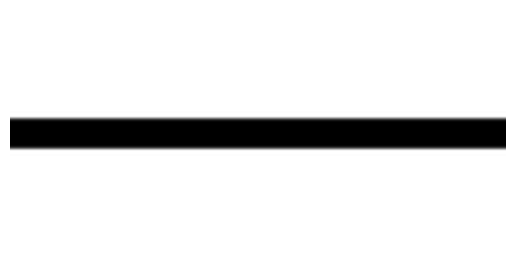

In [8]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')
plt.show()

Getting results

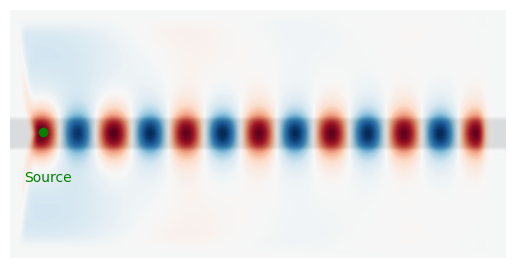

In [9]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.plot(10,39,'go')
plt.text(4,55,'Source',color='g')
plt.axis('off')
plt.show()

# 90 Bend

In [25]:
cell = mp.Vector3(16,16,0)
geometry = [mp.Block(mp.Vector3(12,1,mp.inf),
                     center=mp.Vector3(-2.5,-3.5),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(1,12,mp.inf),
                     center=mp.Vector3(3.5,2),
                     material=mp.Medium(epsilon=12))]
pml_layers = [mp.PML(1.0)]
resolution = 10


SrcWavelen = 2*(11**0.5)
SrcWid = 20

sources = [mp.Source(mp.ContinuousSource(wavelength=SrcWavelen, width=SrcWid),
                     component=mp.Ez,
                     center=mp.Vector3(-7,-3.5),
                     size=mp.Vector3(0,1))]

display(Math(f'Source~info:~~~Wavelength = {SrcWavelen:1.4f} μm,~~~ Width:~{SrcWid}μm,~~~Frequency = {(1/SrcWavelen):1.4f}'))

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

<IPython.core.display.Math object>

To calculate the simulation time, the number of time units must be calculated:

$1/f = T$, if $f = 0.15$, then $T \approx 6$. So if we want to simulate 100 periods, then it must have $6 \cdot 100 = 600$ time units. If we want to simulate 0.1 periods, then it must have $6 \cdot 0.1 = 0.6$ time units.

In [26]:
sim.run(mp.at_beginning(mp.output_epsilon),   # At the start of the simulation only, output the epsilon
        mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),  # At each 0.6 time units (approx. 0.1 wavelength periods), output Ez
        until=200)

# These additional configurations to sim.run() generates data files, each config generate a single 3d HDF5 file.

!mv ez.h5 pngComponents/Bend90/ez.h5 
!mv eps-000000.00.h5 pngComponents/Bend90/eps-000000.00.h5 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000177145 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.022511 s
-----------
creating output file "./eps-000000.00.h5"...
creating output file "./ez.h5"...
run 0 finished at t = 200.0 (4000 timesteps)


In [27]:
!h5ls pngComponents/Bend90/ez.h5  # Analyzing contents of HDF5 file

ez                       Dataset {160, 160, 333/Inf}


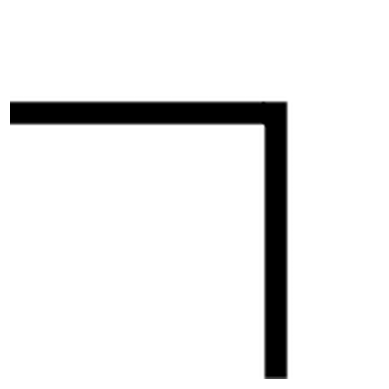

In [20]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')
plt.show()

In [28]:
# Converts h5 file into gif
!h5topng -t 0:332-R -Zc dkbluered -a yarg -A pngComponents/Bend90/eps-000000.00.h5 pngComponents/Bend90/ez.h5 # h5 to png
!convert pngComponents/Bend90/ez.t*.png pngComponents/Bend90/ez.gif # png to gif
!rm pngComponents/Bend90/ez.t*.png # png removal